# Análisis de Cobertura y Uso del Suelo (LULC) — Ecuador

Este notebook proporciona una metodología completa para el **análisis de cobertura y uso del suelo** utilizando datos de MapBiomas Ecuador. El procedimiento incluye la descarga de mapas anuales, el recorte espacial a áreas de cuencas hidrográficas, el cálculo de estadísticas zonales por clase de cobertura y la visualización de cambios temporales.

**Objetivos del análisis:**
- Descarga automatizada de **mapas de cobertura** para períodos específicos (ej. 2005 y 2023)
- Procesamiento espacial utilizando archivos de **cuencas hidrográficas (basins.gpkg)**
- Cálculo de porcentajes de cobertura por clase y análisis de cambios temporales
- Generación de **visualizaciones** (nacional y por cuenca) para reportes técnicos


[![Abrir en Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1LFOh_0k75De0KZGEZJd60gMlW6KhqCVc?usp=sharing)

## Dependencias del Sistema
La siguiente celda instala las librerías necesarias para el análisis. En entornos como Google Colab, algunas dependencias ya están preinstaladas:


In [1]:
# Instalación de dependencias requeridas para el análisis geoespacial
!pip -q install geopandas rasterio rasterstats shapely requests matplotlib

## ⚙️ Configuración de Parámetros
Seleccione **dos años** para el análisis comparativo (por ejemplo, 2005 y 2023). Los mapas correspondientes se descargarán automáticamente desde la base de datos de MapBiomas Ecuador.


In [2]:
# Configuración de años para el análisis comparativo
YEAR_A = 2005  # Año inicial del período de análisis
YEAR_B = 2023  # Año final del período de análisis

# Directorio base para almacenamiento de datos y resultados
BASE_DIR = "mapbiomas_data" 

## Descarga de Datos (MapBiomas + Cuencas Hidrográficas)
- **Fuente de datos**: MapBiomas Ecuador (https://ecuador.mapbiomas.org)  
- **Formato**: Descarga directa de mapas raster (GeoTIFF) por año desde repositorio público.  
- **Geometría de análisis**: Archivo `basins.gpkg` con delimitación de cuencas hidrográficas.

> **Nota**: Los archivos existentes en el directorio local no se descargan nuevamente.


In [ ]:
import geopandas as gpd, rasterio, rasterio.mask, pandas as pd, requests, re, os
from rasterstats import zonal_stats
from pathlib import Path

def download_file(url, file_path: Path):
    """Descarga un archivo desde una URL al directorio especificado."""
    file_path.parent.mkdir(parents=True, exist_ok=True)
    with requests.get(url, stream=True) as response:
        response.raise_for_status()
        with open(file_path, "wb") as file:
            for chunk in response.iter_content(1024*1024):
                if chunk: file.write(chunk)

def get_mapbiomas_url(year): 
    """Genera la URL de descarga para un año específico de MapBiomas Ecuador."""
    return f"https://storage.googleapis.com/mapbiomas-public/initiatives/ecuador/collection_2/lulc/mapbiomas_ecuador_collection2_integration_v1-classification_{year}.tif"

# Configuración de rutas de archivos
base = Path(BASE_DIR)
tifA = base / f"ecuador_coverage_{YEAR_A}.tif"
tifB = base / f"ecuador_coverage_{YEAR_B}.tif"
url_A, url_B = get_mapbiomas_url(YEAR_A), get_mapbiomas_url(YEAR_B)

basin_gpkg = base / "basins.gpkg"
url_basins = "https://github.com/ccardenas93/ecociencia/blob/main/LULC_Analysis/mapbiomas_data/basins.gpkg"

# Descarga de archivos (solo si no existen localmente)
if not tifA.exists(): download_file(url_A, tifA)
if not tifB.exists(): download_file(url_B, tifB)
if not basin_gpkg.exists(): download_file(url_basins, basin_gpkg)

print("Descarga completada - Archivos disponibles:")
print(" -", tifA)
print(" -", tifB)
print(" -", basin_gpkg)

Descarga completada - Archivos disponibles:
 - mapbiomas_data/ecuador_coverage_2005.tif
 - mapbiomas_data/ecuador_coverage_2023.tif
 - mapbiomas_data/basins.gpkg


## Configuración de Leyenda y Preparación de Geometría
Se procesan las cuencas hidrográficas para el recorte de los rásteres y se establece el **Sistema de Coordenadas de Referencia (CRS)** apropiado.


In [4]:
legend = {
 1: "1. Formación Forestal", 3: "1.1. Bosque", 4: "1.2. Bosque abierto", 5: "1.3. Manglar",
 6: "1.4. Bosque inundable", 10: "2. Formación natural no forestal",
 11: "2.1. Formación natural no forestal inundable", 12: "2.2. Herbazal",
 29: "2.3. Afloramiento rocoso", 13: "2.4. Otra formación natural no forestal",
 14: "3. Agropecuaria y silvicultura", 9: "3.3 Silvicultura",
 21: "3.5 Mosaico de agricultura y/o pastos", 22: "4. Área sin vegetación",
 23: "4.1. Playa, duna o banco de arena", 24: "4.2. Infraestructura urbana",
 30: "4.3. Minería", 68: "4.4. Otra área natural sin vegetación",
 25: "4.5. Otra área antrópica sin vegetación", 26: "5. Cuerpo de agua",
 33: "5.1 Río, lago u océano", 34: "5.2 Glaciar", 31: "5.3 Acuicultura", 27: "6. No observado"
}

basins = gpd.read_file(basin_gpkg)

with rasterio.open(tifB) as src:
    raster_crs, nodata_val = src.crs, src.nodata

basins = basins.to_crs(raster_crs)

try:
    mask_geom = [basins.union_all()]
except Exception:
    mask_geom = [basins.unary_union]

## Procesamiento de Ráster y Cálculo de Estadísticas Zonales
- **Recorte espacial**: Cada mapa se recorta al área de las cuencas hidrográficas.
- **Análisis estadístico**: Se calculan porcentajes de cobertura por clase para cada cuenca y período.
- **Exportación**: Se genera un archivo CSV con el formato **`landcover_percentage_YYYY_YYYY.csv`**.


In [5]:
def mask_raster(input_path: Path, output_path: Path, mask_geometry):
    """Recorta un ráster utilizando una geometría de máscara."""
    with rasterio.open(input_path) as source:
        masked_image, masked_transform = rasterio.mask.mask(source, mask_geometry, crop=True)
        metadata = source.meta.copy()
        metadata.update({"height": masked_image.shape[1],
                         "width": masked_image.shape[2],
                         "transform": masked_transform})
    with rasterio.open(output_path, "w", **metadata) as destination:
        destination.write(masked_image)

# Generación de archivos recortados
masked_A = base / f"masked_{YEAR_A}.tif"
masked_B = base / f"masked_{YEAR_B}.tif"
if not masked_A.exists(): mask_raster(tifA, masked_A, mask_geom)
if not masked_B.exists(): mask_raster(tifB, masked_B, mask_geom)

# Configuración de parámetros para estadísticas zonales
zonal_stats_params = {"categorical": True}
if nodata_val is not None:
    zonal_stats_params["nodata"] = nodata_val

# Cálculo de estadísticas zonales para ambos períodos
stats_A = zonal_stats(basins, masked_A, **zonal_stats_params)
stats_B = zonal_stats(basins, masked_B, **zonal_stats_params)

# Procesamiento de datos y cálculo de porcentajes
results = []
for i, basin in basins.iterrows():
    data_A, data_B = stats_A[i], stats_B[i]
    total_A, total_B = sum(data_A.values()), sum(data_B.values())
    classes = {int(k) for k in set(data_A.keys()).union(data_B.keys()) if re.fullmatch(r"\d+", str(k))}
    
    basin_results = []
    for class_id in classes:
        count_A, count_B = data_A.get(class_id, 0), data_B.get(class_id, 0)
        basin_results.append({
            "HYBAS_ID": basin["HYBAS_ID"],
            "pixel_id": class_id,
            "clase_de_cobertura": legend.get(int(class_id), f"Desconocido {class_id}"),
            f"pct_{YEAR_A}": (count_A / total_A) * 100 if total_A else 0,
            f"pct_{YEAR_B}": (count_B / total_B) * 100 if total_B else 0
        })
    # Ordenamiento por porcentaje del año final (descendente)
    basin_results.sort(key=lambda x: x[f"pct_{YEAR_B}"], reverse=True)
    results.extend(basin_results)

# Exportación de resultados a CSV
output_csv = base / f"landcover_percentage_{YEAR_A}_{YEAR_B}.csv"
pd.DataFrame(results).to_csv(output_csv, index=False, encoding="utf-8-sig")
print("Archivo CSV generado:", output_csv.resolve())

/Users/carsk8/miniforge3/lib/python3.12/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


Archivo CSV generado: /Volumes/Carsk8Mac/GitHub/ecociencia/LULC_Analysis/mapbiomas_data/landcover_percentage_2005_2023.csv


## Visualización Nacional: Análisis de Cambios por Clase de Cobertura
Genera un gráfico que muestra el **cambio total en porcentaje** por clase de cobertura a nivel nacional.


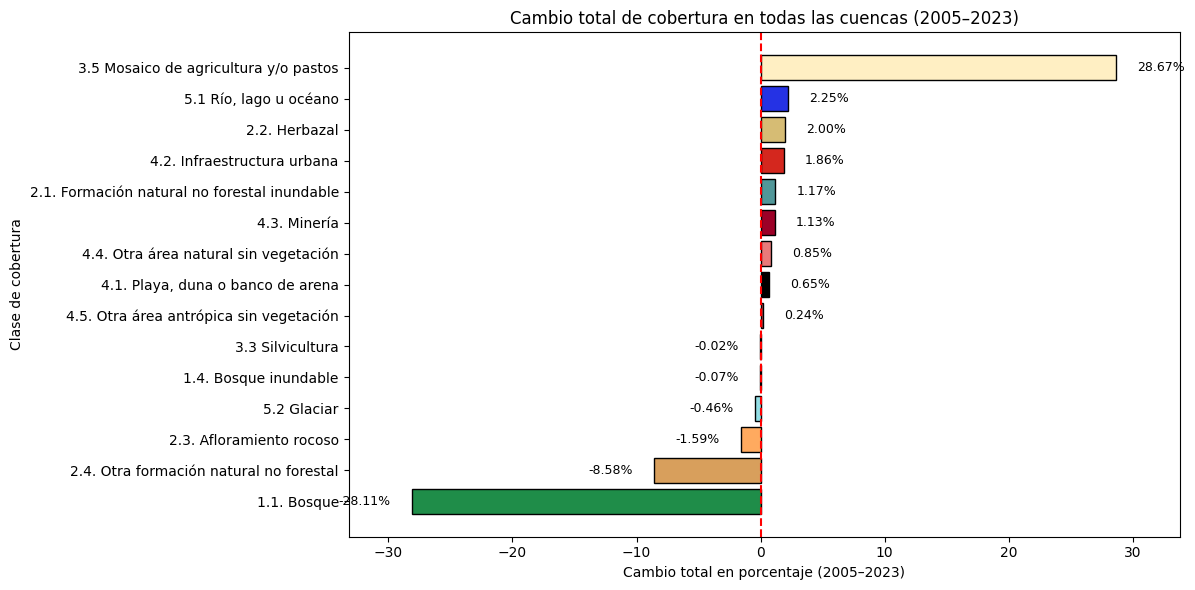

In [6]:
import matplotlib.pyplot as plt

# Carga de datos procesados
file_path = output_csv
df = pd.read_csv(file_path)

# Paleta de colores estándar para clases de cobertura MapBiomas
color_map = {
    "1.1. Bosque": "#1f8d49","1.2. Bosque abierto": "#7dc975","1.3. Manglar": "#04381d","1.4. Bosque inundable": "#026975",
    "2.2. Herbazal": "#d6bc74","2.1. Formación natural no forestal inundable": "#519799","2.3. Afloramiento rocoso": "#ffaa5f",
    "2.4. Otra formación natural no forestal": "#d89f5c","3.3 Silvicultura": "#7a5900","3.5 Mosaico de agricultura y/o pastos": "#ffefc3",
    "4.2. Infraestructura urbana": "#d4271e","4.3. Minería": "#9c0027","4.4. Otra área natural sin vegetación": "#e97a7a",
    "4.5. Otra área antrópica sin vegetación": "#db4d4f","5.1 Río, lago u océano": "#2532e4","5.2 Glaciar": "#93dfe6","5.3 Acuicultura": "#091077"
}

# Cálculo de cambios porcentuales
col_A, col_B = f"pct_{YEAR_A}", f"pct_{YEAR_B}"
df["change_pct"] = df[col_B] - df[col_A]
overall_changes = df.groupby("clase_de_cobertura", as_index=False)["change_pct"].sum().sort_values("change_pct", ascending=False)

# Configuración del gráfico
plt.figure(figsize=(12,6))
colors = [color_map.get(landcover_class, "#000000") for landcover_class in overall_changes["clase_de_cobertura"]]
bars = plt.barh(overall_changes["clase_de_cobertura"], overall_changes["change_pct"], color=colors, edgecolor="black")

# Ajuste de escalas y etiquetas
xmin, xmax = float(overall_changes["change_pct"].min()), float(overall_changes["change_pct"].max())
xrange = xmax - xmin if xmax != xmin else (abs(xmax) if xmax != 0 else 1.0)
padding = 0.03 * xrange
plt.xlim(xmin - 3*padding, xmax + 3*padding)

# Etiquetado de barras
for bar in bars:
    width = bar.get_width()
    y_position = bar.get_y() + bar.get_height()/2
    x_text = width + (padding if width>=0 else -padding)
    plt.text(x_text, y_position, f"{width:.2f}%", va="center", ha="left" if width>=0 else "right", fontsize=9, color="black")

# Configuración de ejes y título
plt.xlabel(f"Cambio total en porcentaje ({YEAR_A}–{YEAR_B})")
plt.ylabel("Clase de cobertura")
plt.title(f"Cambio total de cobertura en todas las cuencas ({YEAR_A}–{YEAR_B})")
plt.axvline(0, color="red", linestyle="--")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Visualización por Cuenca Hidrográfica (HYBAS_ID)
Genera gráficos individuales por cuenca hidrográfica, con **barras ordenadas** de mayor a menor cambio y **etiquetas** con precisión de 2 decimales.


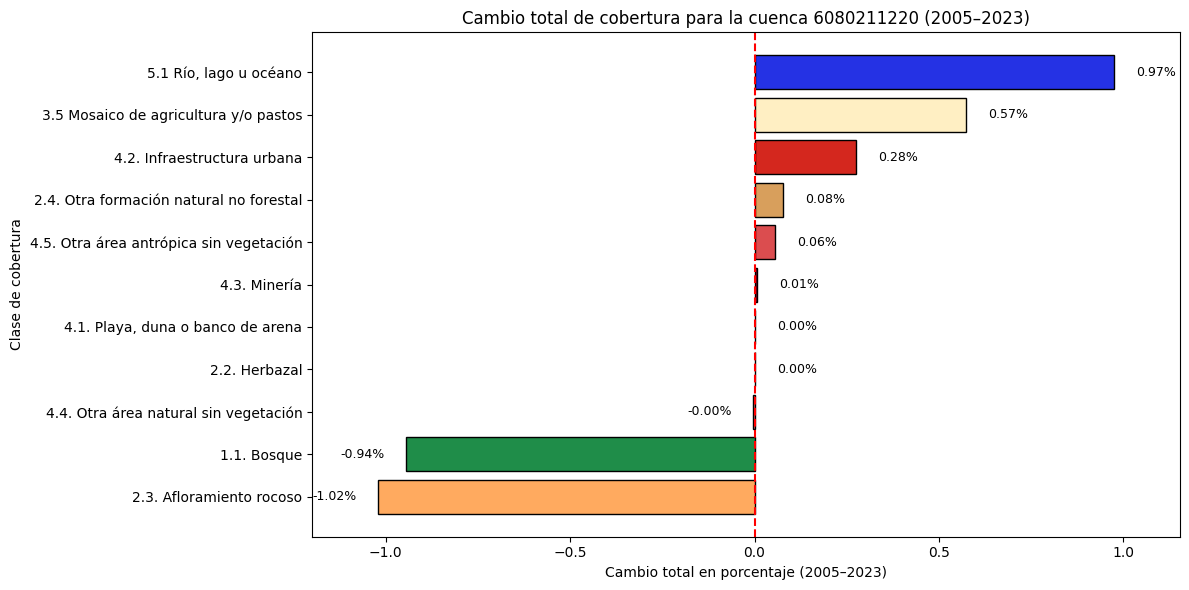

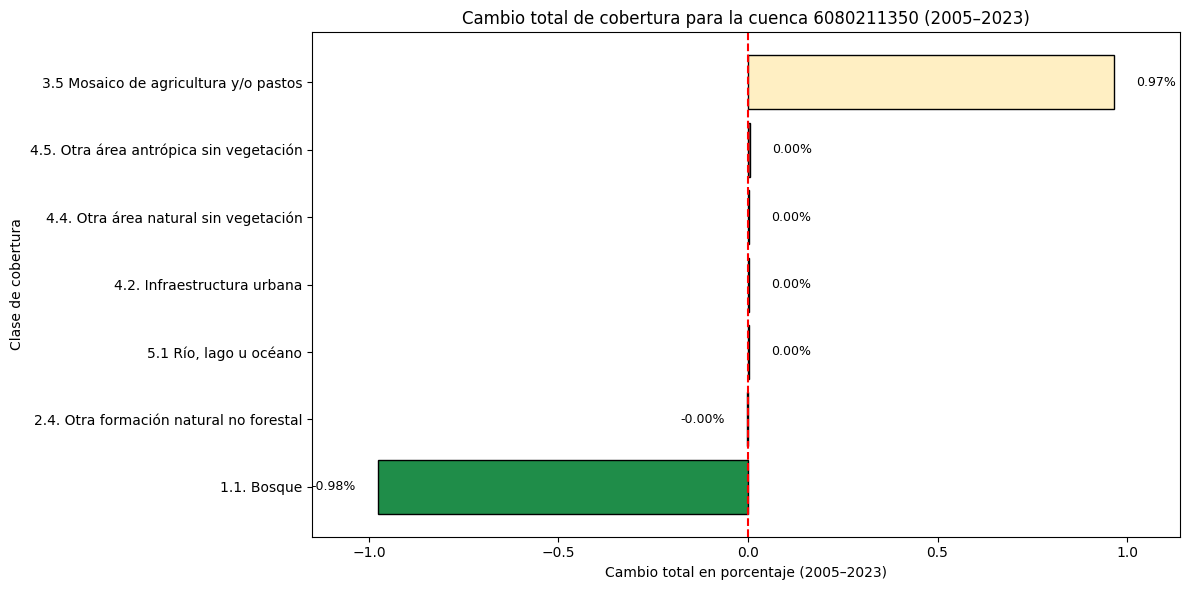

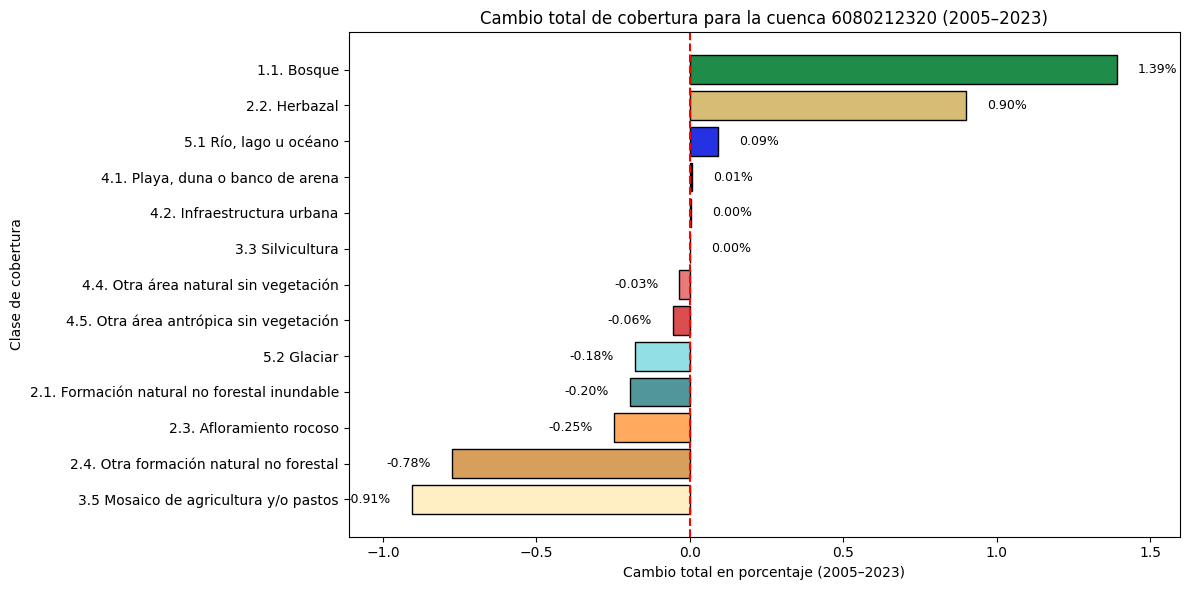

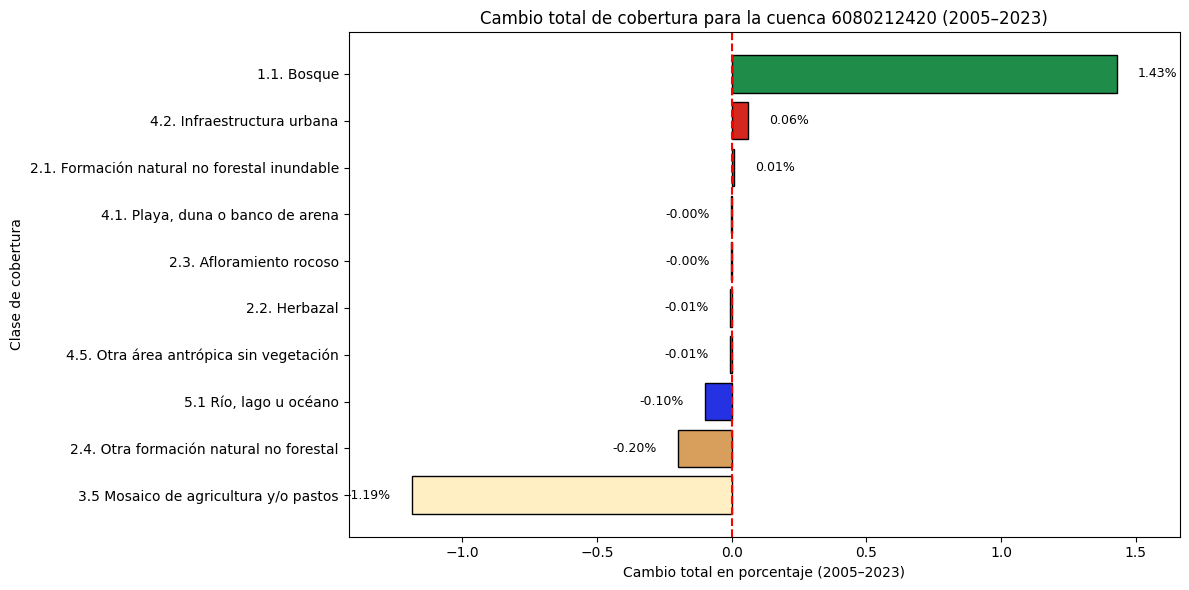

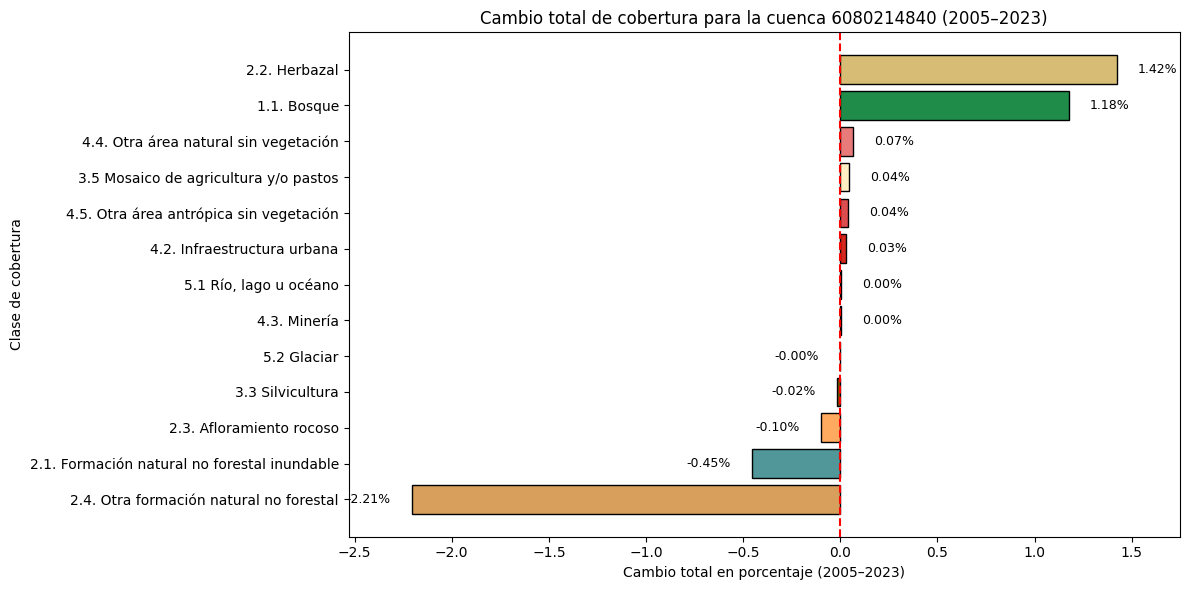

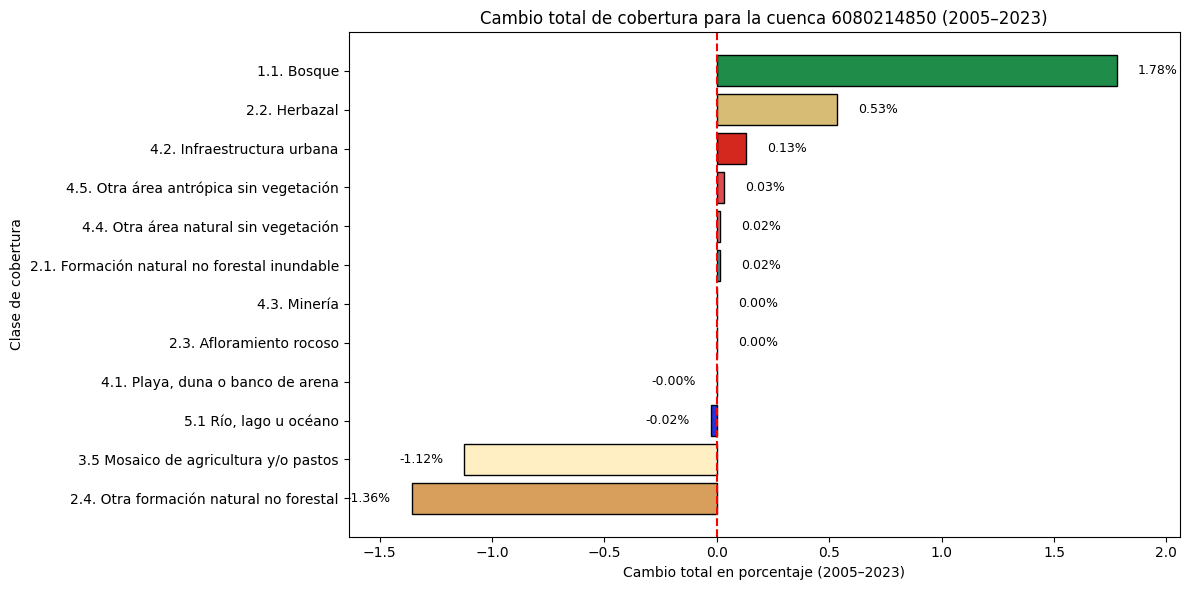

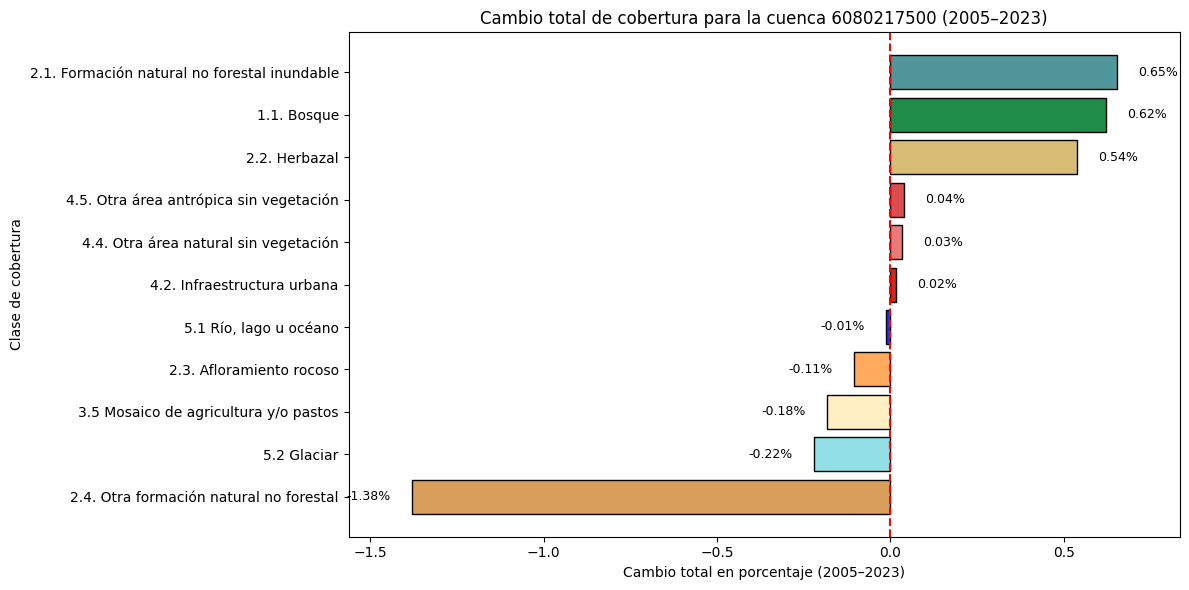

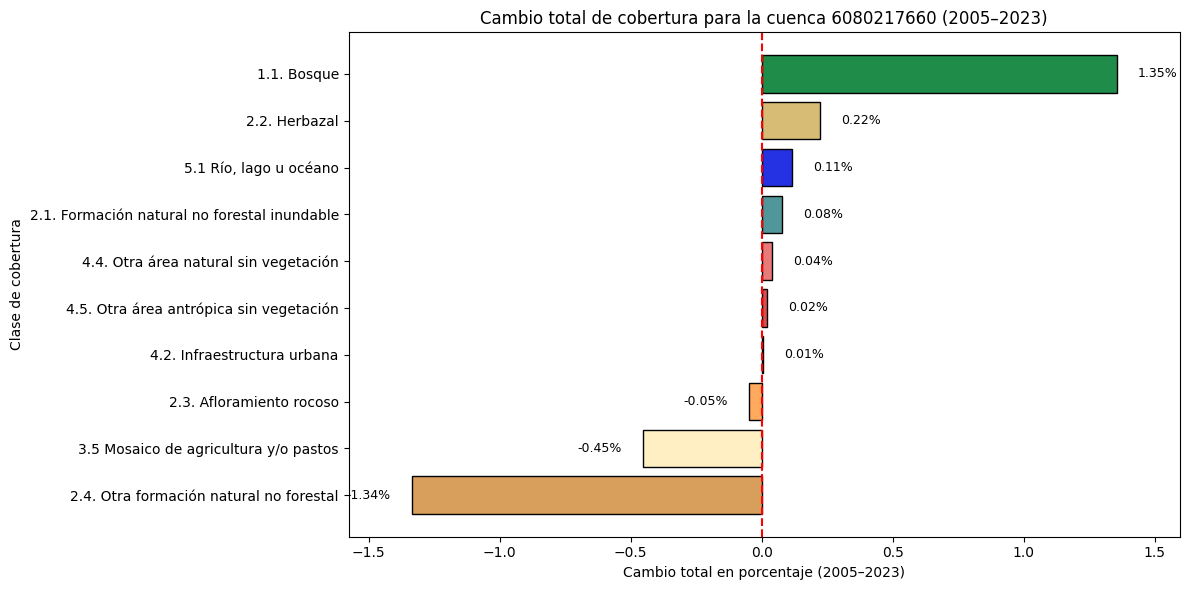

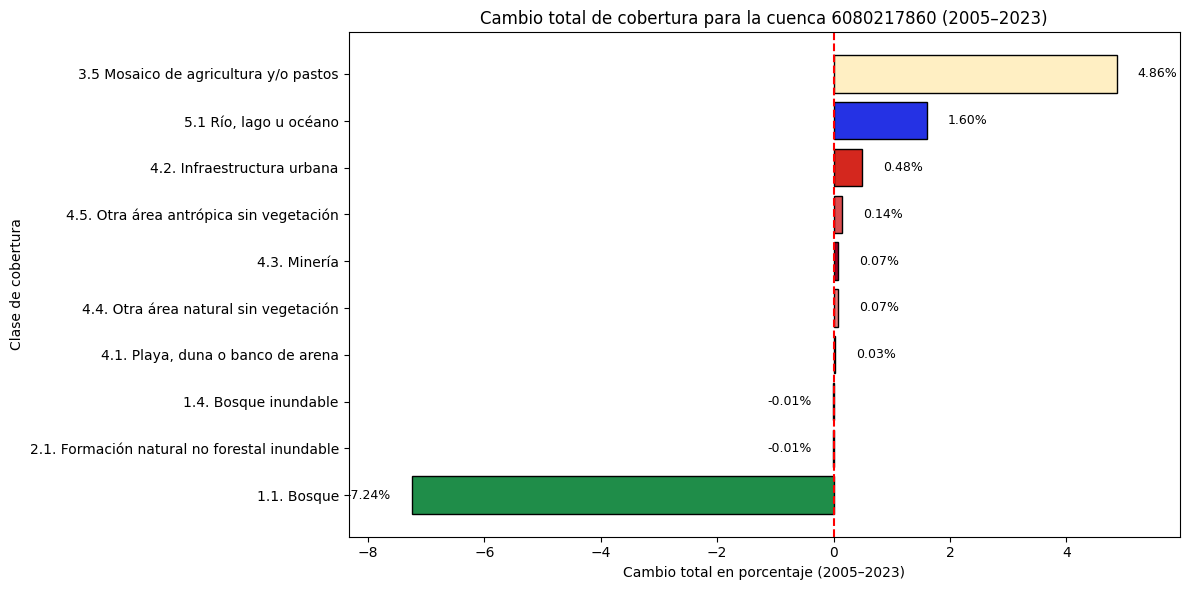

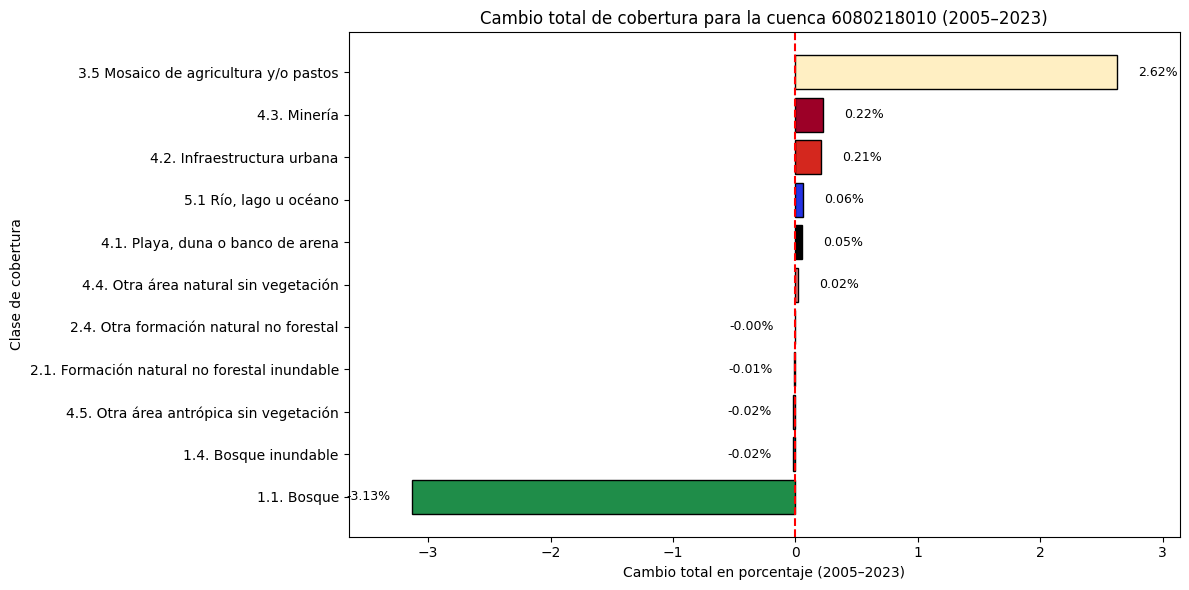

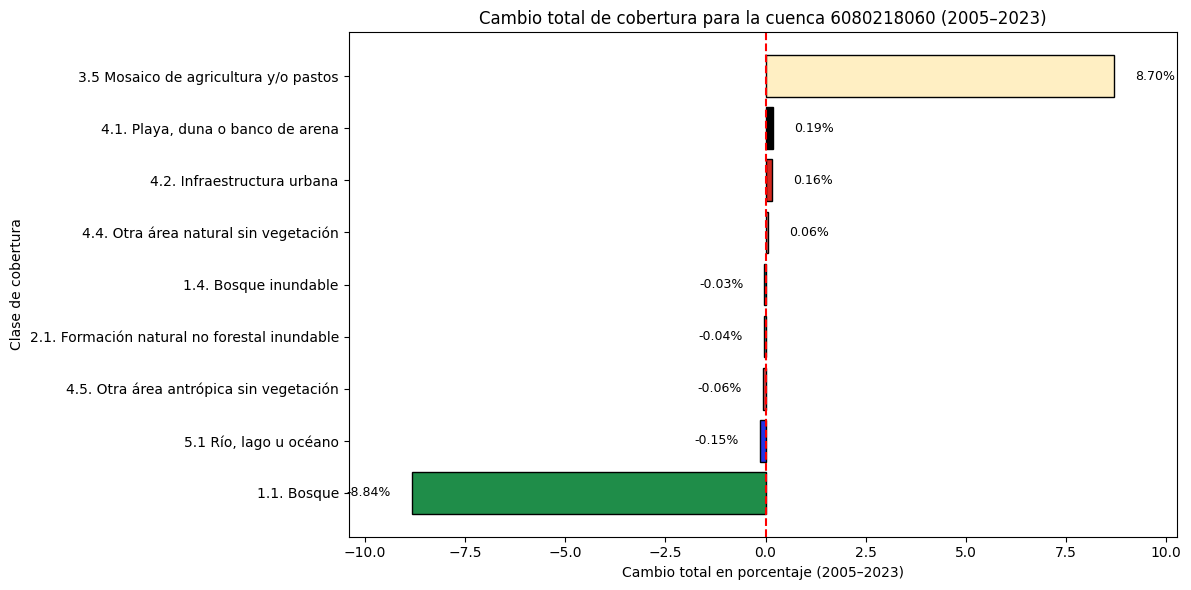

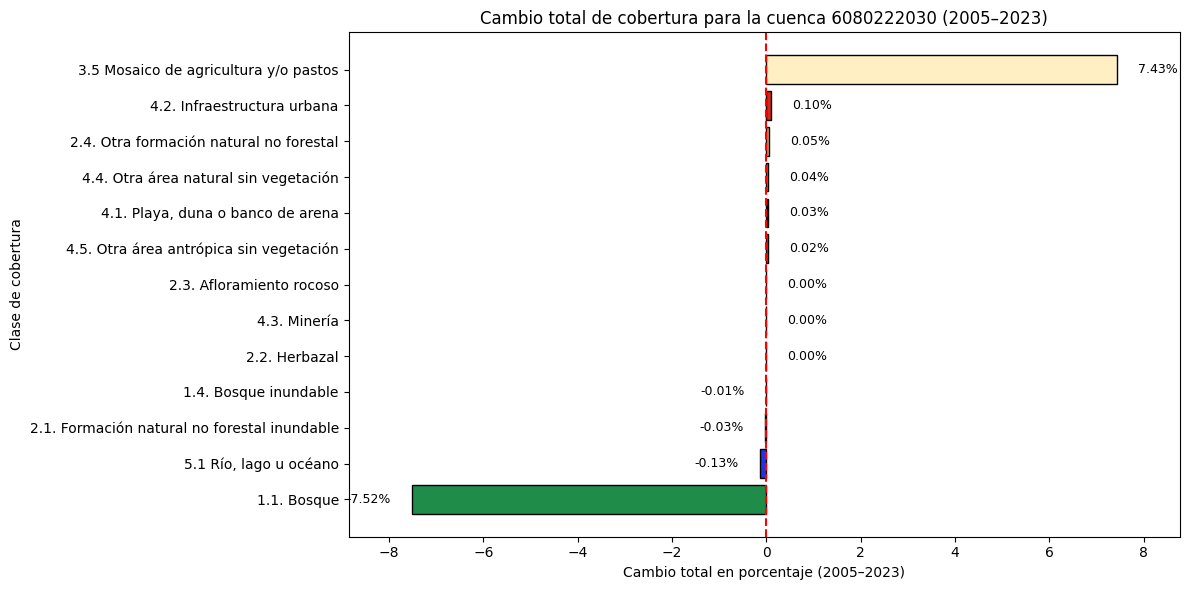

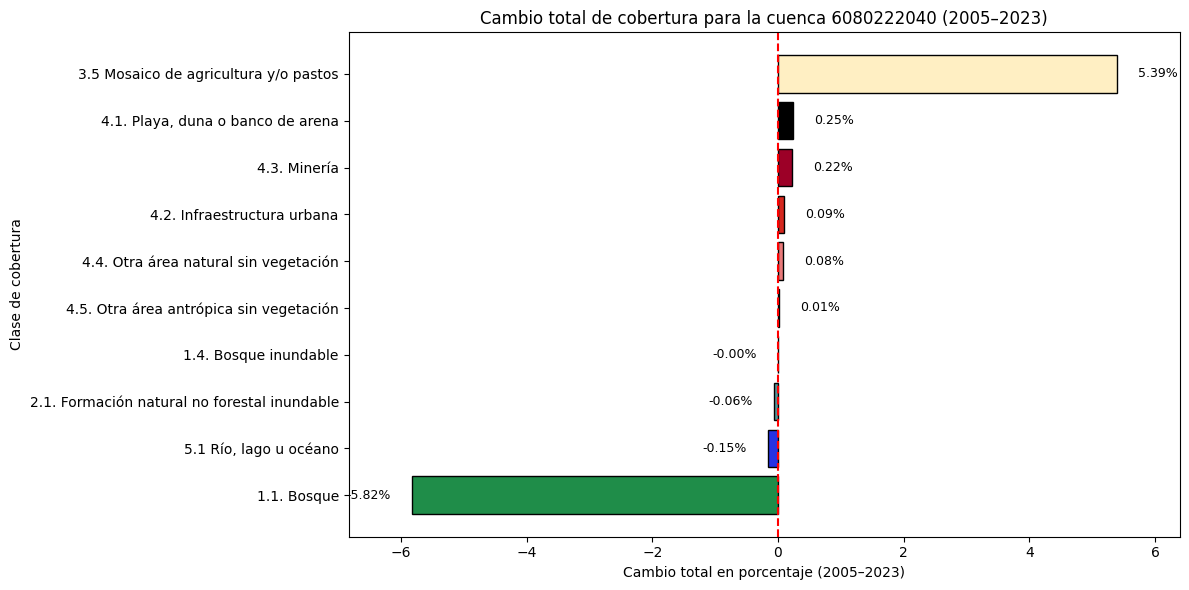

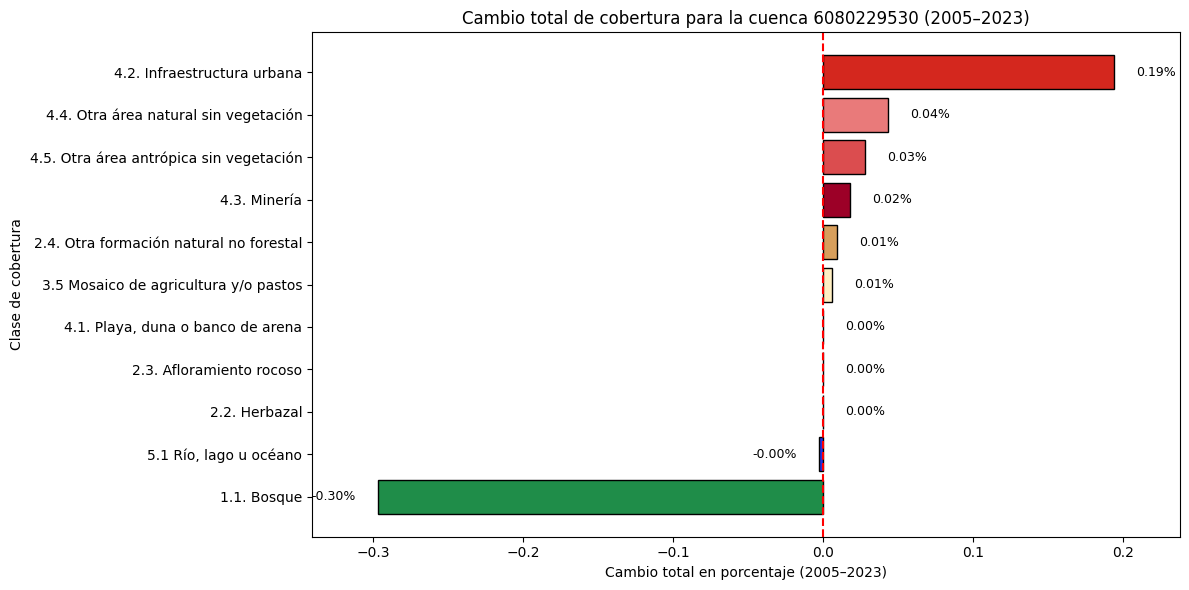

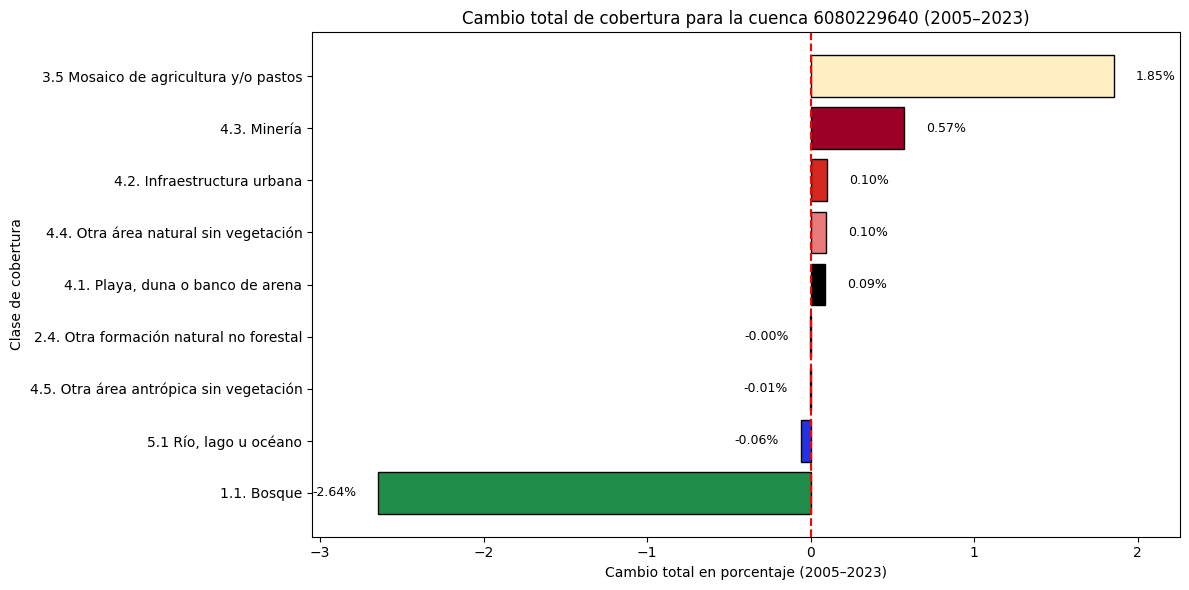

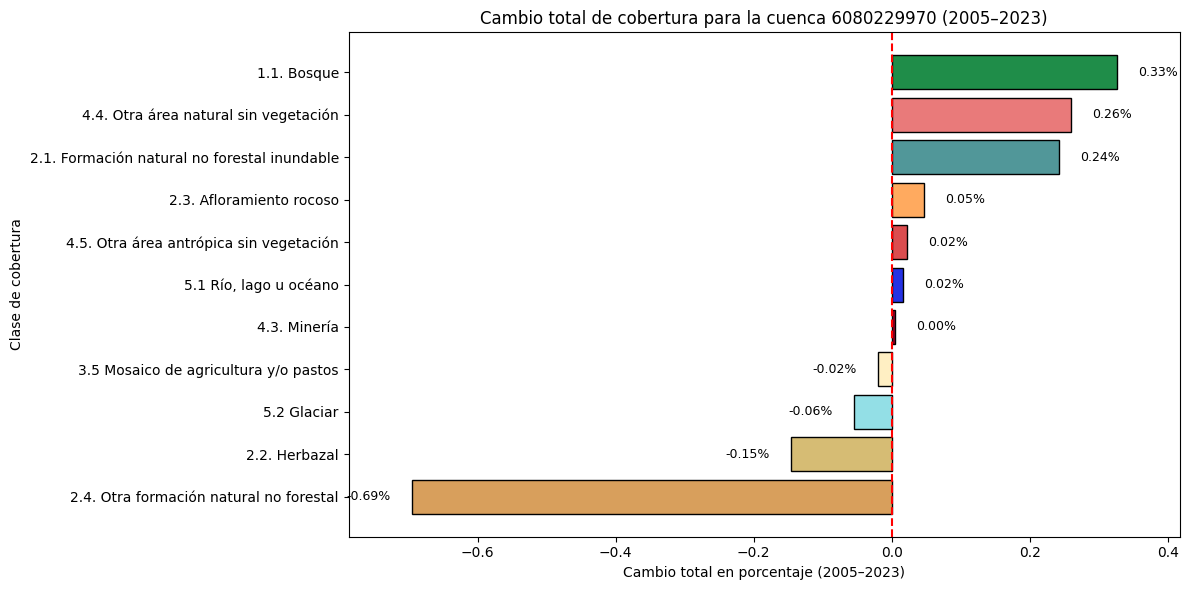

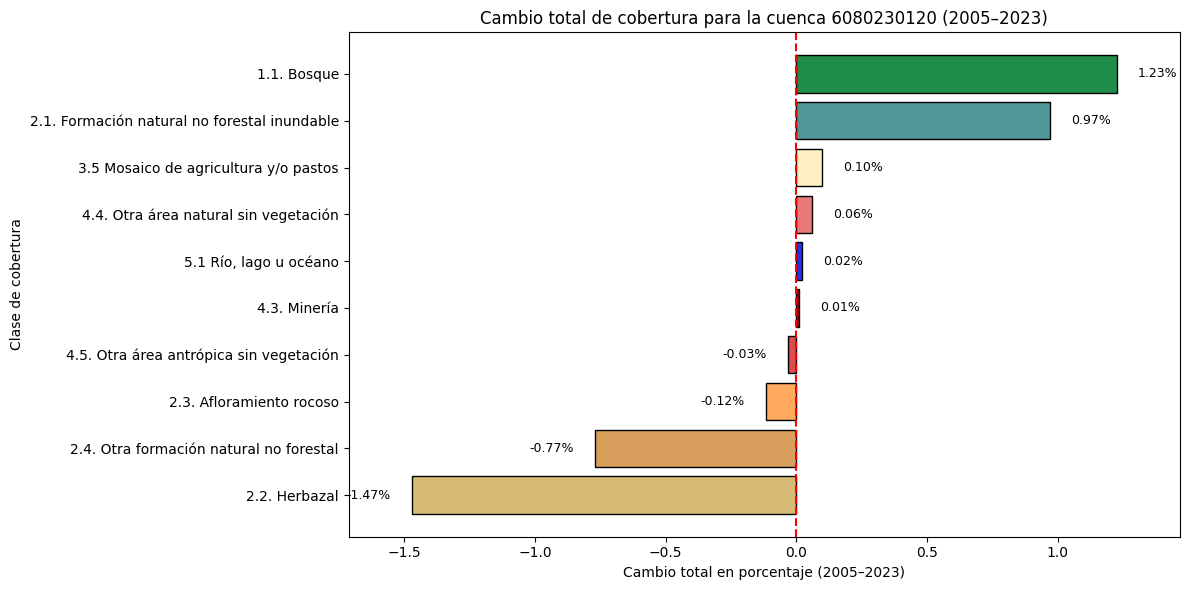

In [7]:
# Agrupación de datos por cuenca hidrográfica
basin_data = df.groupby(["HYBAS_ID", "clase_de_cobertura"])["change_pct"].sum().reset_index()

# Generación de gráficos individuales por cuenca
for basin_id, basin_data in basin_data.groupby("HYBAS_ID"):
    basin_data = basin_data.sort_values("change_pct", ascending=False)
    fig, ax = plt.subplots(figsize=(12,6))

    # Aplicación de colores según la paleta estándar
    colors = [color_map.get(landcover_class, "#000000") for landcover_class in basin_data["clase_de_cobertura"]]

    # Creación de gráfico de barras horizontales
    bars = ax.barh(basin_data["clase_de_cobertura"], basin_data["change_pct"], color=colors, edgecolor="black")

    # Cálculo de escalas y ajuste de límites
    xmin, xmax = float(basin_data["change_pct"].min()), float(basin_data["change_pct"].max())
    xrange = xmax - xmin if xmax != xmin else (abs(xmax) if xmax != 0 else 1.0)
    padding = 0.03 * xrange
    ax.set_xlim(xmin - 3*padding, xmax + 3*padding)

    # Etiquetado de barras con valores
    for bar in bars:
        width = bar.get_width()
        y_position = bar.get_y() + bar.get_height()/2
        x_text = width + (padding if width>=0 else -padding)
        ax.text(x_text, y_position, f"{width:.2f}%", va="center", ha="left" if width>=0 else "right", fontsize=9, color="black")

    # Configuración de ejes y título
    ax.set_xlabel(f"Cambio total en porcentaje ({YEAR_A}–{YEAR_B})")
    ax.set_ylabel("Clase de cobertura")
    ax.set_title(f"Cambio total de cobertura para la cuenca {basin_id} ({YEAR_A}–{YEAR_B})")
    ax.axvline(0, color="red", linestyle="--")
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

## Exportación de Figuras (Opcional)
Para guardar las figuras generadas en formato PNG, descomente la línea `plt.savefig(...)` correspondiente.


In [ ]:
# Ejemplo de exportación de figura nacional (descomente para utilizar)
# plt.figure(figsize=(12,6))
# ... código para generar la figura ...
# plt.savefig(Path(BASE_DIR)/f"cambio_total_{YEAR_A}_{YEAR_B}.png", dpi=200, bbox_inches="tight")

## Consideraciones Técnicas y Solución de Problemas

### Advertencias y Errores Comunes
- **`NodataWarning`**: El código maneja automáticamente los valores nodata cuando están presentes en el ráster. Si persiste la advertencia, puede especificar `nodata=0` en los parámetros de `zonal_stats`.

### Modificaciones del Análisis
- **Cambio de años**: Para analizar diferentes períodos, modifique `YEAR_A` y `YEAR_B` y ejecute nuevamente desde la sección de descarga de datos.
- **Actualización de geometrías**: Si el archivo `basins.gpkg` cambia, actualice la URL correspondiente en la celda de descarga.
- **Identificadores de cuenca**: Verifique que el campo `HYBAS_ID` existe en su archivo de cuencas; de lo contrario, ajuste la clave correspondiente en el código.
